<a href="https://colab.research.google.com/github/TommyCai-git/TMDB-Popularity-Prediction/blob/main/TMDB_Popularity_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Part 0 Load packages, load data

In [2]:
import sklearn as sl
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split

In [3]:
import requests
import pandas as pd

API_KEY = "d19e5875240cf339de83377430e631ea"


DISCOVER_URL = "https://api.themoviedb.org/3/discover/movie"
DETAILS_URL = "https://api.themoviedb.org/3/movie"


def fetch_movies(api_key, pages=1):
    movie_data = []

    for page in range(1, pages + 1):

        discover_params = {
            "api_key": api_key,
            "language": "en-US",
            "sort_by": "release_date.asc",
            "release_date.gte": "2010-01-01",
            "page": page
        }

        discover_response = requests.get(DISCOVER_URL, params=discover_params)
        if discover_response.status_code == 200:
            discover_results = discover_response.json().get("results", [])

            for movie in discover_results:
                    movie_id = movie.get("id")
                    title = movie.get("title")
                    release_date = movie.get("release_date", "Unknown")
                    release_year = release_date.split("-")[0] if release_date else None
                    popularity = movie.get("popularity")
                    vote_average = movie.get("vote_average")
                    vote_count = movie.get("vote_count")


                    details_response = requests.get(f"{DETAILS_URL}/{movie_id}", params={"api_key": api_key})
                    if details_response.status_code == 200:
                        details = details_response.json()
                        runtime = details.get("runtime", None)
                        genres = [genre["name"] for genre in details.get("genres", [])]
                        budget = details.get("budget", 0)


                        movie_data.append({
                            "Title": title,
                            "Movie ID": movie_id,
                            "Release Year": release_year,
                            "Genres": genres,
                            "Popularity": popularity,
                            "Vote Average": vote_average,
                            "Vote Count": vote_count,
                            "Duration (mins)": runtime,
                            "Budget (USD)": budget
                        })

    return movie_data


movies = fetch_movies(API_KEY, pages=100)


df = pd.DataFrame(movies)


In [4]:
df.tail(5)

,Title,Movie ID,Release Year,Genres,Popularity,Vote Average,Vote Count,Duration (mins),Budget (USD)
1995,Band of Outsiders,8073,1964,"[Crime, Drama, Comedy]",9.802,7.500,558,97,120000
1996,Three for a Robbery,500027,1964,"[Crime, Drama]",0.749,0.000,0,87,0
1997,The Castle of the Living Dead,28592,1964,[Horror],2.006,5.967,30,90,0
1998,Men and Women,195450,1964,[Drama],3.267,7.233,30,93,0
1999,The Gorgon,28667,1964,"[Horror, Fantasy]",9.604,6.300,146,83,0


In [5]:
df.shape

(2000, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            2000 non-null   object 
 1   Movie ID         2000 non-null   int64  
 2   Release Year     2000 non-null   object 
 3   Genres           2000 non-null   object 
 4   Popularity       2000 non-null   float64
 5   Vote Average     2000 non-null   float64
 6   Vote Count       2000 non-null   int64  
 7   Duration (mins)  2000 non-null   int64  
 8   Budget (USD)     2000 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 140.8+ KB


# **Part 1: Data Exploration**

## 1.1 Exclude erroneous data

In [7]:
if df['Movie ID'].duplicated().sum()==0:
  print('no duplicated index')

no duplicated index


## 1.2 Understand numerical features

In [8]:
df.drop(columns=['Movie ID','Title','Release Year'],axis=1).describe(percentiles=[0.1,0.25,0.5,0.75,0.95])

,Popularity,Vote Average,Vote Count,Duration (mins),Budget (USD)
count,2000.000000,2000.000000,2000.000000,2000.000000,2.000000e+03
mean,6.356946,5.781626,229.817000,81.905000,3.423922e+05
std,7.781196,2.305073,720.118091,41.772173,1.763215e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00
10%,0.436800,0.000000,0.000000,9.000000,0.000000e+00
25%,1.339500,5.600000,6.000000,70.000000,0.000000e+00
50%,4.011000,6.500000,31.000000,89.000000,0.000000e+00
75%,8.947250,7.100000,133.000000,104.000000,0.000000e+00
95%,18.586300,7.900000,968.100000,134.000000,2.000000e+06
max,111.825000,10.000000,10087.000000,425.000000,4.400000e+07


In [9]:
(df==0).sum(axis=0)/df.shape[0]

,0
Title,0.0000
Movie ID,0.0000
Release Year,0.0000
Genres,0.0000
Popularity,0.0005
Vote Average,0.1155
Vote Count,0.1155
Duration (mins),0.0310
Budget (USD),0.8470


## 1.2.1 popularity distribution

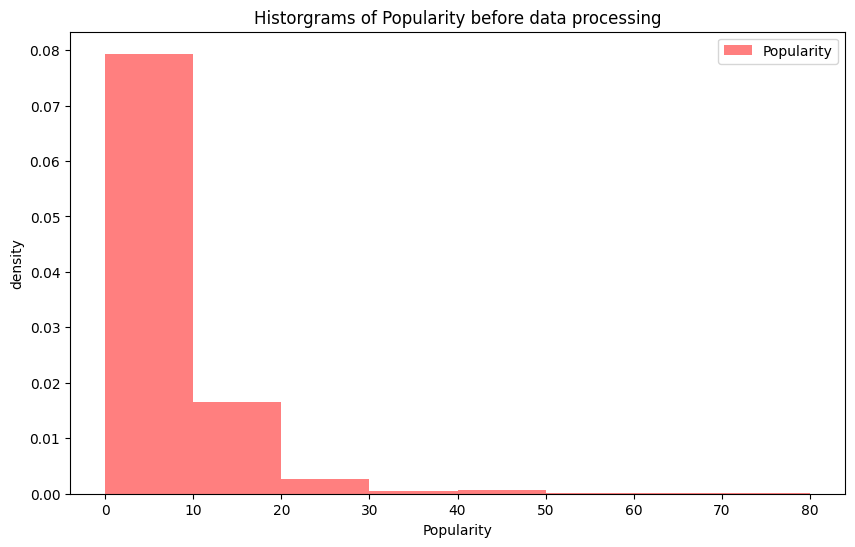

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
plt.hist(df['Popularity'],bins=range(0,85,10),color='r',label='Popularity',density=True,alpha=0.5)
plt.title('Historgrams of Popularity before data processing')
plt.legend(loc='upper right')
plt.xlabel('Popularity')
plt.ylabel('density')
plt.show()

### 1.2.2 Correlation among numerical features

<Axes: >

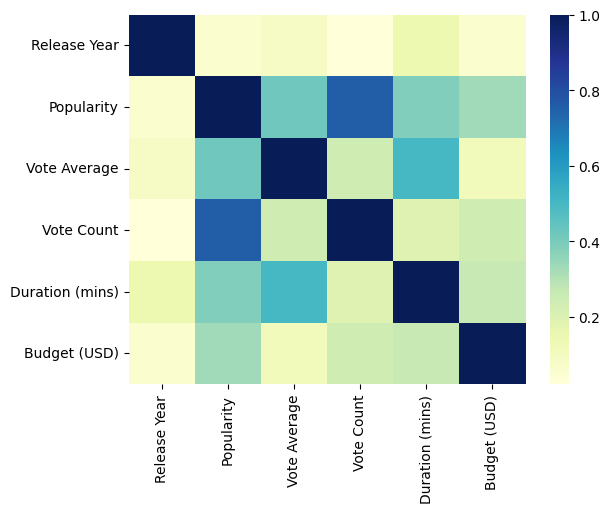

In [11]:
corr = df[['Release Year','Popularity','Vote Average', 'Vote Count', 'Duration (mins)', 'Budget (USD)']].corr()

sns.heatmap(corr, cmap="YlGnBu")

In [12]:
corr

,Release Year,Popularity,Vote Average,Vote Count,Duration (mins),Budget (USD)
Release Year,1.000000,0.056160,0.084200,0.021129,0.143659,0.056152
Popularity,0.056160,1.000000,0.419700,0.753729,0.388062,0.332917
Vote Average,0.084200,0.419700,1.000000,0.242405,0.500409,0.115898
Vote Count,0.021129,0.753729,0.242405,1.000000,0.191816,0.241548
Duration (mins),0.143659,0.388062,0.500409,0.191816,1.000000,0.264009
Budget (USD),0.056152,0.332917,0.115898,0.241548,0.264009,1.000000


### 1.3 Understand categorical features

In [13]:
df['Genres'] = df['Genres'].astype(str).str.replace('[\[\]]', '', regex=True)

In [14]:
df['Genres']

,Genres
0,'Music'
1,'Documentary'
2,'Documentary'
3,'Documentary'
4,'Documentary'
...,...
1995,"'Crime', 'Drama', 'Comedy'"
1996,"'Crime', 'Drama'"
1997,'Horror'
1998,'Drama'


'Action'              93
'Adventure'          160
'Animation'           95
'Comedy'             422
'Crime'              262
'Documentary'        219
'Drama'              979
'Family'              70
'Fantasy'             99
'History'             98
'Horror'             146
'Music'               95
'Mystery'            136
'Romance'            384
'Science Fiction'     92
'TV Movie'            12
'Thriller'           229
'War'                132
'Western'            104
dtype: int64


<Axes: >

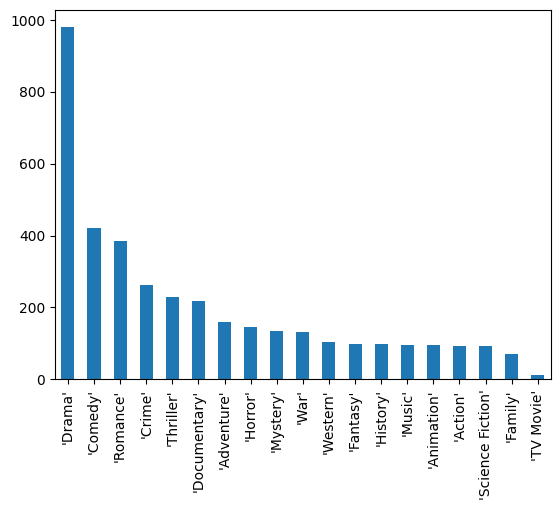

In [15]:
gen_split = df['Genres'].str.get_dummies(sep=', ').sum()
print(gen_split)

gen_split.sort_values(ascending=False).plot.bar()

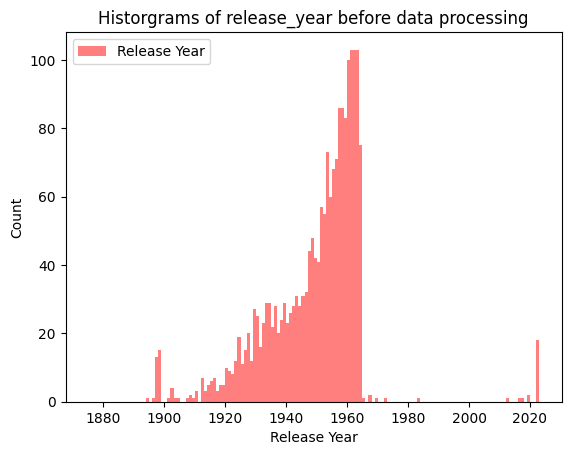

In [16]:
df['Release Year'] = df['Release Year'].astype(int)
plt.hist(df['Release Year'].values, bins = range(1875, 2024, 1), alpha = 0.5, color='r', label = 'Release Year')
plt.legend(loc ='upper left')
plt.title('Historgrams of release_year before data processing')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.show()


# Part 2: Feature Preprocessing

### 2.1 Categorical features

In [17]:
import numpy as np
d_genres=df['Genres'].str.get_dummies(sep=', ').astype(np.int64)

In [18]:
df['Release Year'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

,Release Year
0.1,1928.0
0.2,1936.8
0.3,1944.0
0.4,1949.0
0.5,1953.0
0.6,1956.0
0.7,1958.0
0.8,1961.0
0.9,1963.0


In [19]:
bin_year = [1890, 1901, 1911, 1921, 1931, 1941, 1951, 2001,2024]
year_range = ['1890-1900', '1901-1910', '1911-1920', '1921-1930','1931-1940','1941-1950','1951-2000','2001-2024']

year_bin = pd.cut(df['Release Year'], bin_year, labels=year_range)
d_year = pd.get_dummies(year_bin).astype(np.int64)

In [20]:
temp_df=df.drop(['Genres', 'Release Year'], axis=1)

newdf = pd.concat([temp_df,d_genres, d_year], axis=1)
newdf.head()

,Title,Movie ID,Popularity,Vote Average,Vote Count,Duration (mins),Budget (USD),'Action','Adventure','Animation',...,'War','Western',1890-1900,1901-1910,1911-1920,1921-1930,1931-1940,1941-1950,1951-2000,2001-2024
0,Dickson Experimental Sound Film,104396,4.616,6.2,101,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,"Pont du Mont-Blanc, Genève",1067334,0.073,1.0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,Toboggan aquatique,1059234,0.041,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Marché à Berne,1066402,0.001,0.0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Zermatt : Panorama dans les Alpes,786511,0.001,0.0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### 2.2 Missing data

In [21]:
newdf[['Popularity','Vote Average','Vote Count', 'Duration (mins)','Budget (USD)']] = newdf[['Popularity','Vote Average','Vote Count', 'Duration (mins)','Budget (USD)']].replace(0, np.nan)
print(newdf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              2000 non-null   object 
 1   Movie ID           2000 non-null   int64  
 2   Popularity         1999 non-null   float64
 3   Vote Average       1769 non-null   float64
 4   Vote Count         1769 non-null   float64
 5   Duration (mins)    1938 non-null   float64
 6   Budget (USD)       306 non-null    float64
 7   'Action'           2000 non-null   int64  
 8   'Adventure'        2000 non-null   int64  
 9   'Animation'        2000 non-null   int64  
 10  'Comedy'           2000 non-null   int64  
 11  'Crime'            2000 non-null   int64  
 12  'Documentary'      2000 non-null   int64  
 13  'Drama'            2000 non-null   int64  
 14  'Family'           2000 non-null   int64  
 15  'Fantasy'          2000 non-null   int64  
 16  'History'          2000 

In [22]:
newdf1=newdf.copy()
newdf1['Popularity']=newdf1['Popularity'].fillna(newdf1['Popularity'].mean())
newdf1['Vote Average']=newdf1['Vote Average'].fillna(newdf1['Vote Average'].mean())
newdf1['Vote Count']=newdf1['Vote Count'].fillna(newdf1['Vote Count'].mean())
newdf1['Duration (mins)']=newdf1['Duration (mins)'].fillna(newdf1['Duration (mins)'].mean())
newdf1['Budget (USD)']=newdf1['Budget (USD)'].fillna(newdf1['Budget (USD)'].mean())
print(newdf1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              2000 non-null   object 
 1   Movie ID           2000 non-null   int64  
 2   Popularity         2000 non-null   float64
 3   Vote Average       2000 non-null   float64
 4   Vote Count         2000 non-null   float64
 5   Duration (mins)    2000 non-null   float64
 6   Budget (USD)       2000 non-null   float64
 7   'Action'           2000 non-null   int64  
 8   'Adventure'        2000 non-null   int64  
 9   'Animation'        2000 non-null   int64  
 10  'Comedy'           2000 non-null   int64  
 11  'Crime'            2000 non-null   int64  
 12  'Documentary'      2000 non-null   int64  
 13  'Drama'            2000 non-null   int64  
 14  'Family'           2000 non-null   int64  
 15  'Fantasy'          2000 non-null   int64  
 16  'History'          2000 

### 2.3 Feature scaling

In [23]:
scale_lst = ['Vote Average', 'Vote Count', 'Duration (mins)','Budget (USD)']
newdf_sc = newdf1.copy()
sc_scale = preprocessing.StandardScaler().fit(newdf_sc[scale_lst])
newdf_sc[scale_lst] = sc_scale.transform(newdf_sc[scale_lst])
newdf_sc.head()

,Title,Movie ID,Popularity,Vote Average,Vote Count,Duration (mins),Budget (USD),'Action','Adventure','Animation',...,'War','Western',1890-1900,1901-1910,1911-1920,1921-1930,1931-1940,1941-1950,1951-2000,2001-2024
0,Dickson Experimental Sound Film,104396,4.616,-0.346132,-2.220947e-01,-2.135765,0.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,"Pont du Mont-Blanc, Genève",1067334,0.073,-5.693324,-3.619289e-01,-2.135765,0.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,Toboggan aquatique,1059234,0.041,0.000000,7.948660e-17,-2.135765,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Marché à Berne,1066402,0.001,0.000000,7.948660e-17,-2.135765,0.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Zermatt : Panorama dans les Alpes,786511,0.001,0.000000,7.948660e-17,-2.135765,0.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [24]:
newdf_sc.tail(5)

,Title,Movie ID,Popularity,Vote Average,Vote Count,Duration (mins),Budget (USD),'Action','Adventure','Animation',...,'War','Western',1890-1900,1901-1910,1911-1920,1921-1930,1931-1940,1941-1950,1951-2000,2001-2024
1995,Band of Outsiders,8073,9.802,0.990666,4.169481e-01,0.318982,-1.350742,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1996,Three for a Robbery,500027,0.749,0.000000,7.948660e-17,0.063279,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1997,The Castle of the Living Dead,28592,2.006,-0.585727,-3.213770e-01,0.139990,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1998,Men and Women,195450,3.267,0.716109,-3.213770e-01,0.216701,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1999,The Gorgon,28667,9.604,-0.243301,-1.591692e-01,-0.039002,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Part 3: Model Training

In [25]:
train, test = train_test_split(newdf_sc, test_size=0.15, random_state = 3)
model_train_x = train.drop(['Title', 'Movie ID', 'Popularity'], axis = 1)
model_test_x = test.drop(['Title', 'Movie ID', 'Popularity'], axis = 1)
model_train_y = train['Popularity']
model_test_y = test['Popularity']

### 3.1 Lasso linear regression

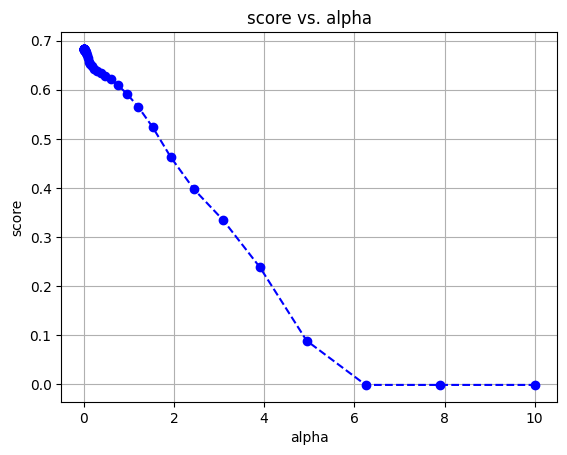

The optimaized alpha and score of Lasso linear is: 


(None, 0.002682695795279727, 0.6832426065301245)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

lr_train, lr_validate = train_test_split(train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.drop(['Title', 'Movie ID', 'Popularity'], axis = 1)
lr_validate_x = lr_validate.drop(['Title', 'Movie ID', 'Popularity'], axis = 1)
lr_train_y = lr_train['Popularity']
lr_validate_y = lr_validate['Popularity']

alphas = np.logspace(-4,1, num=50)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_x, lr_train_y)
    scores[i] = lasso.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
model1_para = opt_a
print ('The optimaized alpha and score of Lasso linear is: '), opt_a, max_score


In [27]:
# combine the validate data and training data, use the optimal alpha, re-train the model
lasso_f = Lasso()
lasso_f.set_params(alpha = opt_a)
lasso_f.fit(model_train_x, model_train_y)

Lasso(alpha=0.002682695795279727)

### 3.2 Ridge linear regression

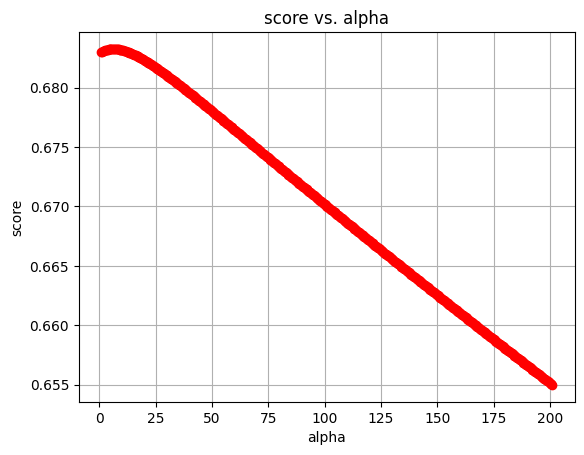

The optimaized alpha and score of Ridge linear is: 


(None, 6.210420841683367, 0.6832666219767556)

In [28]:
lr_train, lr_validate = train_test_split(train, test_size=0.15, random_state = 0)

alphas = np.linspace (1, 201, num=500)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    ridge = Ridge()
    ridge.set_params(alpha = a)
    ridge.fit(lr_train_x, lr_train_y)
    scores[i] = ridge.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        ridge_save = ridge
plt.plot(alphas, scores, color='r', linestyle='dashed', marker='o',markerfacecolor='r', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
model3_para = opt_a
print ('The optimaized alpha and score of Ridge linear is: '), opt_a, max_score

In [29]:


ridge_f = Ridge()
ridge_f.set_params(alpha = opt_a)
ridge_f.fit(model_train_x, model_train_y)


Ridge(alpha=6.210420841683367)

## 3.3 Random Forest

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf=RandomForestRegressor(random_state=2,max_features='sqrt')
param_grid={'n_estimators':[55,56,57,58,59,60,61,62,63,64,65],'max_depth':[15,16,17,18,19,20,21]}
clf=GridSearchCV(estimator=rf,param_grid=param_grid,cv=5)
clf.fit(model_train_x,model_train_y)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features='sqrt',
                                             random_state=2),
             param_grid={'max_depth': [15, 16, 17, 18, 19, 20, 21],
                         'n_estimators': [55, 56, 57, 58, 59, 60, 61, 62, 63,
                                          64, 65]})

{'mean_fit_time': array([0.14581437, 0.14101563, 0.14377503, 0.14770088, 0.19515581,
       0.23721914, 0.25034823, 0.22073359, 0.15876155, 0.16267676,
       0.16327968, 0.14377241, 0.14411378, 0.15262852, 0.15310473,
       0.15563674, 0.1561089 , 0.1618762 , 0.16318607, 0.19076571,
       0.26008   , 0.27718596, 0.20420246, 0.15287919, 0.15183072,
       0.1577745 , 0.15829496, 0.16236629, 0.16490922, 0.16758909,
       0.16997581, 0.17604952, 0.17507243, 0.1518661 , 0.21939411,
       0.24687958, 0.26163869, 0.18339682, 0.16420178, 0.16877446,
       0.20971532, 0.19734755, 0.17737851, 0.17969189, 0.15574632,
       0.15811348, 0.15961542, 0.16367259, 0.24715533, 0.26557789,
       0.2275352 , 0.17525444, 0.17748089, 0.17946205, 0.18303151,
       0.15907793, 0.16062951, 0.1624115 , 0.16776929, 0.17045932,
       0.17590041, 0.22021952, 0.27743397, 0.27914324, 0.18492475,
       0.18798308, 0.1604579 , 0.16221843, 0.16706319, 0.17102971,
       0.17191634, 0.17537408, 0.17889681, 0

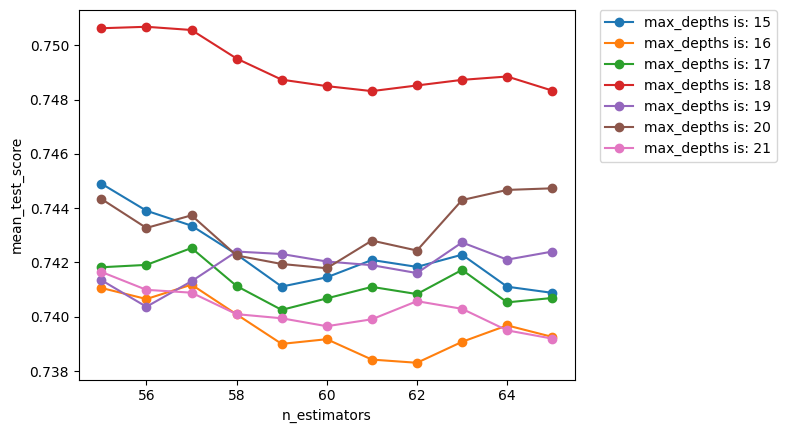

the best parameter for max_depth is: 18
the best parameter for n_estimators is: 56


In [31]:
result=clf.cv_results_
print(result)
max_depth=[15,16,17,18,19,20,21]
n_estimators=[55,56,57,58,59,60,61,62,63,64,65]
scores=clf.cv_results_['mean_test_score'].reshape(len(max_depth),len(n_estimators))
plt.figure(1)
plt.subplot(1,1,1)
for i,j in enumerate(max_depth):
  plt.plot(n_estimators,scores[i],'-o',label='max_depths is: '+str(j))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('n_estimators')
plt.ylabel('mean_test_score')
plt.show()
print('the best parameter for max_depth is: '+str(clf.best_params_['max_depth']))
print('the best parameter for n_estimators is: '+str(clf.best_params_['n_estimators']))



# Part 4: Model Evaluation

## 4.1: Evaluate all models

In [32]:
train_x = model_train_x
train_y = model_train_y
test_x = model_test_x
test_y = model_test_y

In [33]:
#For lasso
from sklearn.linear_model import Lasso
from sklearn.metrics import  mean_squared_error
lasso=Lasso(alpha=model1_para)
lasso.fit(train_x,train_y)
pred_y=lasso.predict(test_x)
lasso_score=lasso.score(test_x,test_y)
MSE_lasso=mean_squared_error(test_y,pred_y)
RMSE_lasso=np.sqrt(MSE_lasso)
print ('lasso score: ', lasso_score)
print ('Mean square error of lasso: ', MSE_lasso)
print ('Root mean squared error of lasso:', RMSE_lasso)

lasso score:  0.6228827628657183
Mean square error of lasso:  21.825749891615512
Root mean squared error of lasso: 4.671803708592166


In [34]:
#for ridge
from sklearn.metrics import  mean_squared_error
ridge=Ridge(alpha=model3_para)
ridge.fit(train_x,train_y)
pred_y=ridge.predict(test_x)
ridge_score=ridge.score(test_x,test_y)
MSE_ridge=mean_squared_error(test_y,pred_y)
RMSE_ridge=np.sqrt(MSE_ridge)
print ('ridge score: ', ridge_score)
print ('Mean square error of ridge: ', MSE_ridge)
print ('Root mean squared error of ridge:', RMSE_ridge)

ridge score:  0.6259425838915502
Mean square error of ridge:  21.648662021195175
Root mean squared error of ridge: 4.652812270143206


In [35]:
#For randomforest regression
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=clf.best_params_['n_estimators'],max_depth=clf.best_params_['max_depth'],
                         max_features='sqrt',random_state=2,n_jobs=-1)
rf.fit(train_x,train_y)
pred_y=rf.predict(test_x)
rf_score=rf.score(test_x,test_y)
MSE_rf=mean_squared_error(test_y,pred_y)
RMSE_rf=np.sqrt(MSE_rf)
print ('rf score: ', rf_score)
print ('Mean square error of rf: ', MSE_rf)
print ('Root mean squared error of rf:', RMSE_rf)


rf score:  0.803201104676635
Mean square error of rf:  11.389782925102805
Root mean squared error of rf: 3.3748752458576607


## 4.2 Model comparison

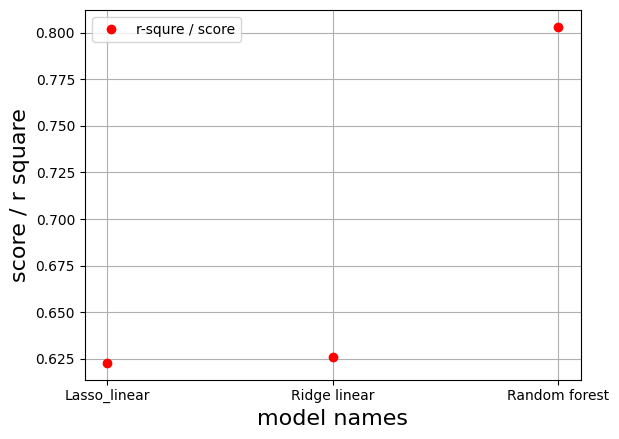

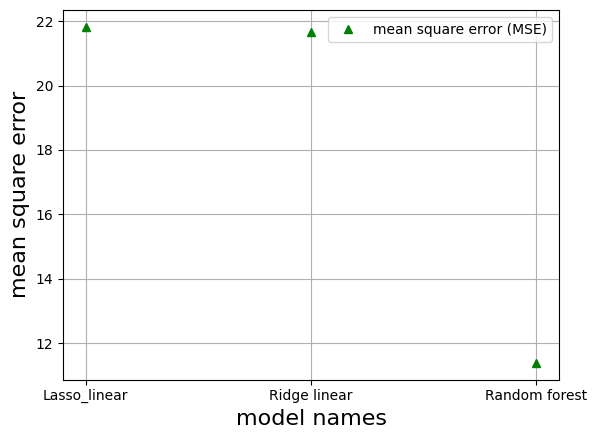

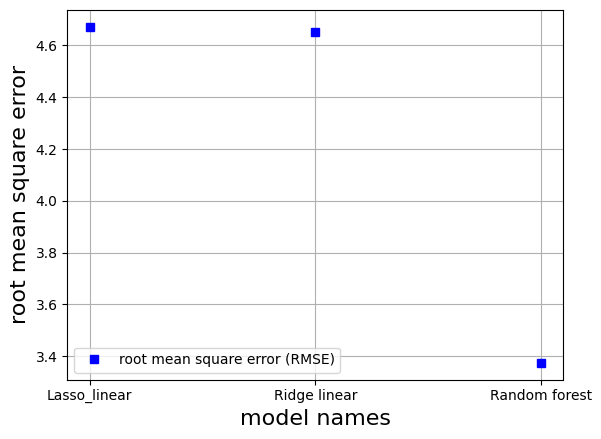

In [36]:
lst_score = [lasso_score, ridge_score, rf_score]
MSE_lst =  [MSE_lasso, MSE_ridge, MSE_rf]
RMSE_lst =  [RMSE_lasso, RMSE_ridge, RMSE_rf]
model_lst = ['Lasso_linear', 'Ridge linear', 'Random forest']

plt.figure(1)
plt.plot(model_lst, lst_score, 'ro')
plt.legend(['r-squre / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(model_lst, MSE_lst, 'g^')
plt.legend(['mean square error (MSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('mean square error', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(3)
plt.plot(model_lst, RMSE_lst, 'bs')
plt.legend(['root mean square error (RMSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('root mean square error', fontsize =16)
plt.grid(True)
plt.show()

## 4.3 Feature importance

According to MSE,RMSE and R square, the Random Forest Regression has the best performance

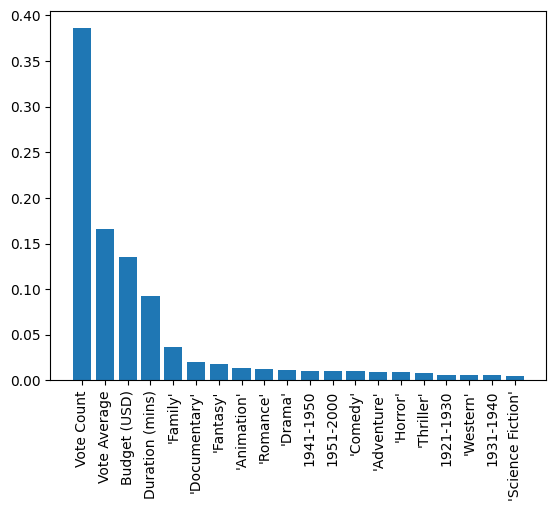

In [37]:
importances = rf.feature_importances_
feature_name = train_x.columns.values
indices = np.argsort(importances)[::-1]
plt.figure(1)
plt.bar(feature_name[indices[:20]], importances[indices[:20]])
plt.xticks(rotation=90)
plt.show()